# EDA: Journey Bike Data 

In [33]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from visualization import journey_data_temporal_vis as vis_temporal
from visualization import station_locations_vis as vis_stations
from visualization import journey_data_weather_vis as vis_weather
from visualization import journey_flow_borough_vis as vis_flow
from visualization import borough_characteristics_vis as vis_boroughs
from data import journey_data_preprocessing as preprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
journey_df = pd.read_csv('../data/interim/journey_data_cleaned_featureeng_1_2_3.csv', parse_dates=['end_date', 'start_date'], index_col=0)

/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 1. JOURNEY DATA: TEMPORAL ANALYSIS

### Frequency Analysis by different Time Intervals

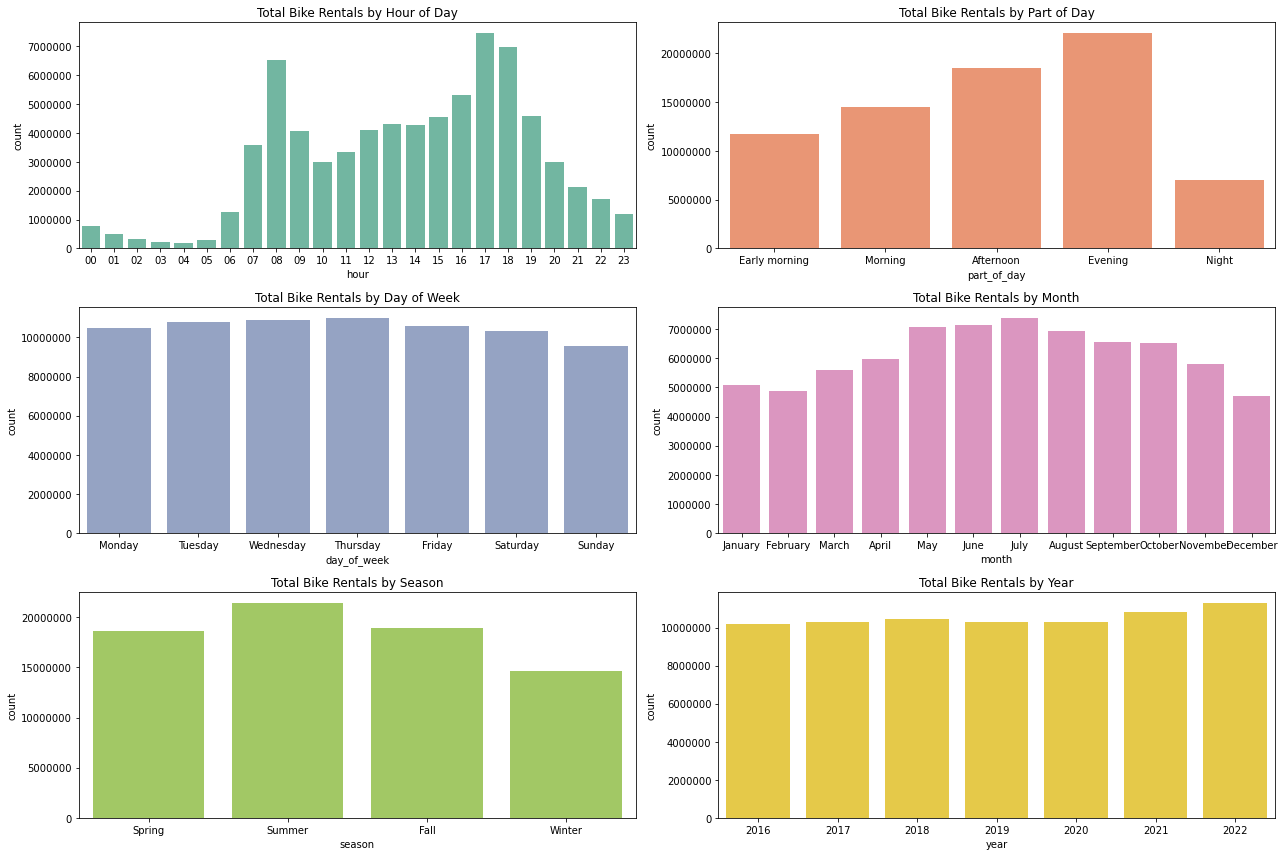

In [3]:
plot_freq = vis_temporal.freq_analysis_time_intervals(journey_df)
plot_freq.show()

### Relationship between Demand and Temporal Variables

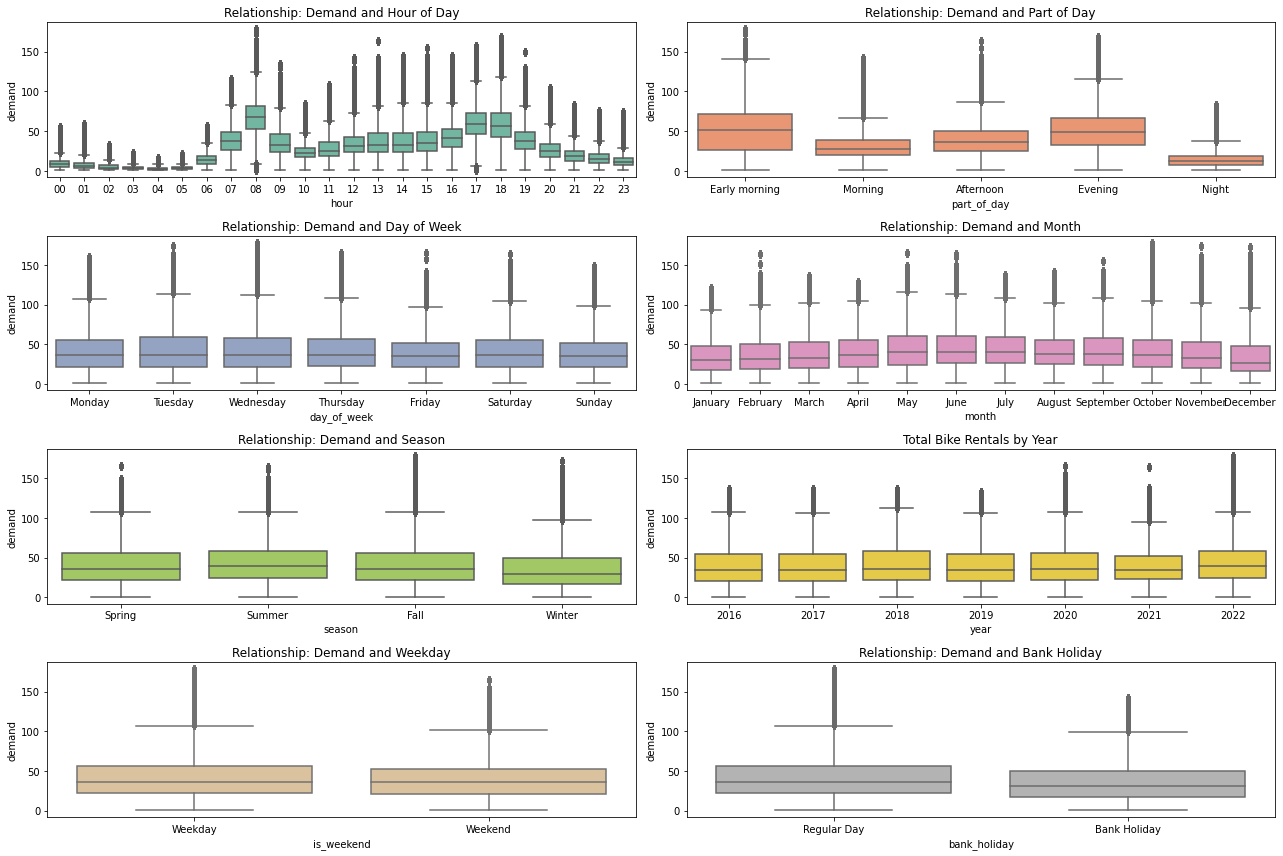

In [7]:
# add 'demand' column (count of 'rental_id')
journey_df_rel = journey_df.copy()
journey_df_rel['demand'] = journey_df_rel.groupby(['start_date', 'hour'])['rental_id'].transform('count')


plot_rel_temporal = vis_temporal.demand_analysis_time_intervals(journey_df_rel)
plot_rel_temporal.show()

### Time Series Decomposed with Impact of Covid Restrictions

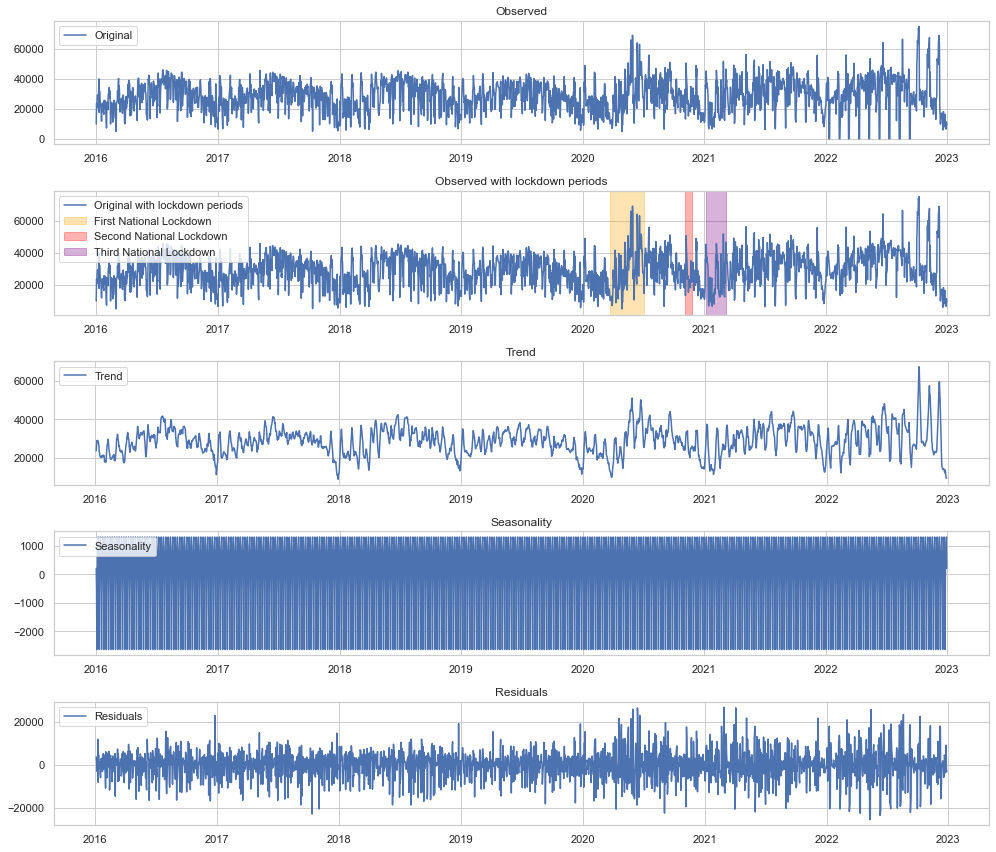

In [133]:
decomposed = seasonal_decompose(journey_df['rental_id'], model='additive')

plot_time_series = vis_temporal.time_series_decomposition(journey_df, decomposed)
plot_time_series.show()

# 2. JOURNEY DATA: WEATHER ANALYSIS

### 2.1 Correlation Weather Features and Demand

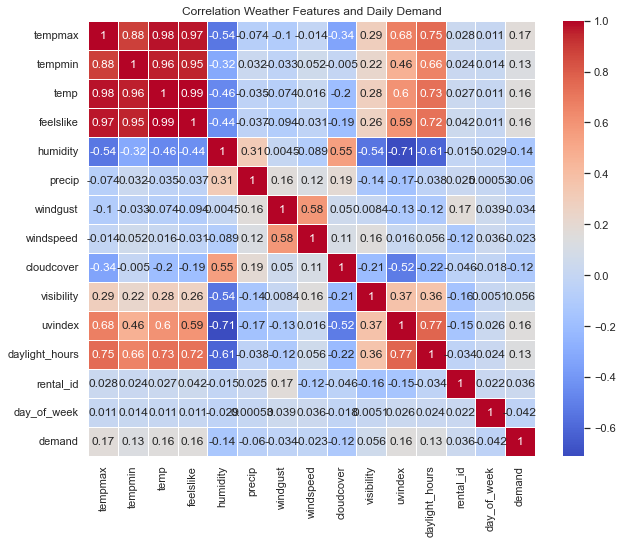

In [14]:
# select weather features
selected_features = ['tempmax', 'tempmin', 'temp', 'feelslike', 'humidity', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex', 'daylight_hours', 'start_date', 'rental_id', 'day_of_week']
journey_df_corr_weather= journey_df.copy()
journey_df_corr_weather = journey_df_corr_weather[selected_features]

#aggregate demand by day (as weather data are only per day)
journey_df_corr_weather['demand'] = journey_df_corr_weather.groupby(['start_date', 'day_of_week'])['rental_id'].transform('count')

# plot
plot_correlation_weather = vis_weather.correlation_plot(journey_df_corr_weather, 'Correlation Weather Features and Daily Demand')
plot_correlation_weather.show()

# 3. BIKE STATION LOCATION ANALYSIS

In [10]:
# import
bike_locs = pd.read_csv('../data/interim/station_locations_boroughs.csv')

# count stations per borough
borough_counts = vis_stations.count_stations_per_borough(bike_locs)

# define density colors
colormap = ["#f7fbff","#f6faff","#f5fafe","#f5f9fe","#f4f9fe","#f3f8fe","#f2f8fd","#f2f7fd","#f1f7fd","#f0f6fd","#eff6fc","#eef5fc","#eef5fc","#edf4fc","#ecf4fb","#ebf3fb","#eaf3fb","#eaf2fb","#e9f2fa","#e8f1fa","#e7f1fa","#e7f0fa","#e6f0f9","#e5eff9","#e4eff9","#e3eef9","#e3eef8","#e2edf8","#e1edf8","#e0ecf8","#e0ecf7","#dfebf7","#deebf7","#ddeaf7","#ddeaf6","#dce9f6","#dbe9f6","#dae8f6","#d9e8f5","#d9e7f5","#d8e7f5","#d7e6f5","#d6e6f4","#d6e5f4","#d5e5f4","#d4e4f4","#d3e4f3","#d2e3f3","#d2e3f3","#d1e2f3","#d0e2f2","#cfe1f2","#cee1f2","#cde0f1","#cce0f1","#ccdff1","#cbdff1","#cadef0","#c9def0","#c8ddf0","#c7ddef","#c6dcef","#c5dcef","#c4dbee","#c3dbee","#c2daee","#c1daed","#c0d9ed","#bfd9ec","#bed8ec","#bdd8ec","#bcd7eb","#bbd7eb","#b9d6eb","#b8d5ea","#b7d5ea","#b6d4e9","#b5d4e9","#b4d3e9","#b2d3e8","#b1d2e8","#b0d1e7","#afd1e7","#add0e7","#acd0e6","#abcfe6","#a9cfe5","#a8cee5","#a7cde5","#a5cde4","#a4cce4","#a3cbe3","#a1cbe3","#a0cae3","#9ec9e2","#9dc9e2","#9cc8e1","#9ac7e1","#99c6e1","#97c6e0","#96c5e0","#94c4df","#93c3df","#91c3df","#90c2de","#8ec1de","#8dc0de","#8bc0dd","#8abfdd","#88bedc","#87bddc","#85bcdc","#84bbdb","#82bbdb","#81badb","#7fb9da","#7eb8da","#7cb7d9","#7bb6d9","#79b5d9","#78b5d8","#76b4d8","#75b3d7","#73b2d7","#72b1d7","#70b0d6","#6fafd6","#6daed5","#6caed5","#6badd5","#69acd4","#68abd4","#66aad3","#65a9d3","#63a8d2","#62a7d2","#61a7d1","#5fa6d1","#5ea5d0","#5da4d0","#5ba3d0","#5aa2cf","#59a1cf","#57a0ce","#569fce","#559ecd","#549ecd","#529dcc","#519ccc","#509bcb","#4f9acb","#4d99ca","#4c98ca","#4b97c9","#4a96c9","#4895c8","#4794c8","#4693c7","#4592c7","#4492c6","#4391c6","#4190c5","#408fc4","#3f8ec4","#3e8dc3","#3d8cc3","#3c8bc2","#3b8ac2","#3a89c1","#3988c1","#3787c0","#3686c0","#3585bf","#3484bf","#3383be","#3282bd","#3181bd","#3080bc","#2f7fbc","#2e7ebb","#2d7dbb","#2c7cba","#2b7bb9","#2a7ab9","#2979b8","#2878b8","#2777b7","#2676b6","#2574b6","#2473b5","#2372b4","#2371b4","#2270b3","#216fb3","#206eb2","#1f6db1","#1e6cb0","#1d6bb0","#1c6aaf","#1c69ae","#1b68ae","#1a67ad","#1966ac","#1865ab","#1864aa","#1763aa","#1662a9","#1561a8","#1560a7","#145fa6","#135ea5","#135da4","#125ca4","#115ba3","#115aa2","#1059a1","#1058a0","#0f579f","#0e569e","#0e559d","#0e549c","#0d539a","#0d5299","#0c5198","#0c5097","#0b4f96","#0b4e95","#0b4d93","#0b4c92","#0a4b91","#0a4a90","#0a498e","#0a488d","#09478c","#09468a","#094589","#094487","#094386","#094285","#094183","#084082","#083e80","#083d7f","#083c7d","#083b7c","#083a7a","#083979","#083877","#083776","#083674","#083573","#083471","#083370","#08326e","#08316d","#08306b"]

# count stations per borough
stations_per_borough = vis_stations.count_stations_per_borough(bike_locs) 

# color mapping dictionary
color_dict = vis_stations.create_color_borough_mapping(colormap, borough_counts) 

### 3.1 Bar Chart: Distribution of Bike Stations across Boroughs

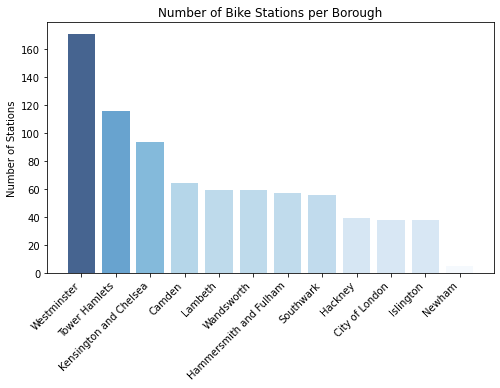

In [5]:
# create chart
barChart = vis_stations.bar_chart_stations_per_borough(color_dict, stations_per_borough)

# save chart
barChart.savefig('../reports/figures/images_bike_station_locations/distribution_stations_across_boroughs.jpg')

# plot
barChart.show()

### 3.2 Visualize Locations and Borough on Map

In [6]:
boroughs_geojson_path = 'https://skgrange.github.io/www/data/london_boroughs.json' 

# create map
borough_station_map = vis_stations.create_borough_station_map(bike_locs, "purple", color_dict, boroughs_geojson_path)

# save the map as an HTML file
borough_station_map.save('../reports/HTML_bike_station_locations/borough_station_map.html')

# plot
display(borough_station_map)

# 4. JOURNEY FLOW ANALYSIS

### 4.1 In-Bound and Out-Bound per Borough

<Figure size 432x288 with 0 Axes>

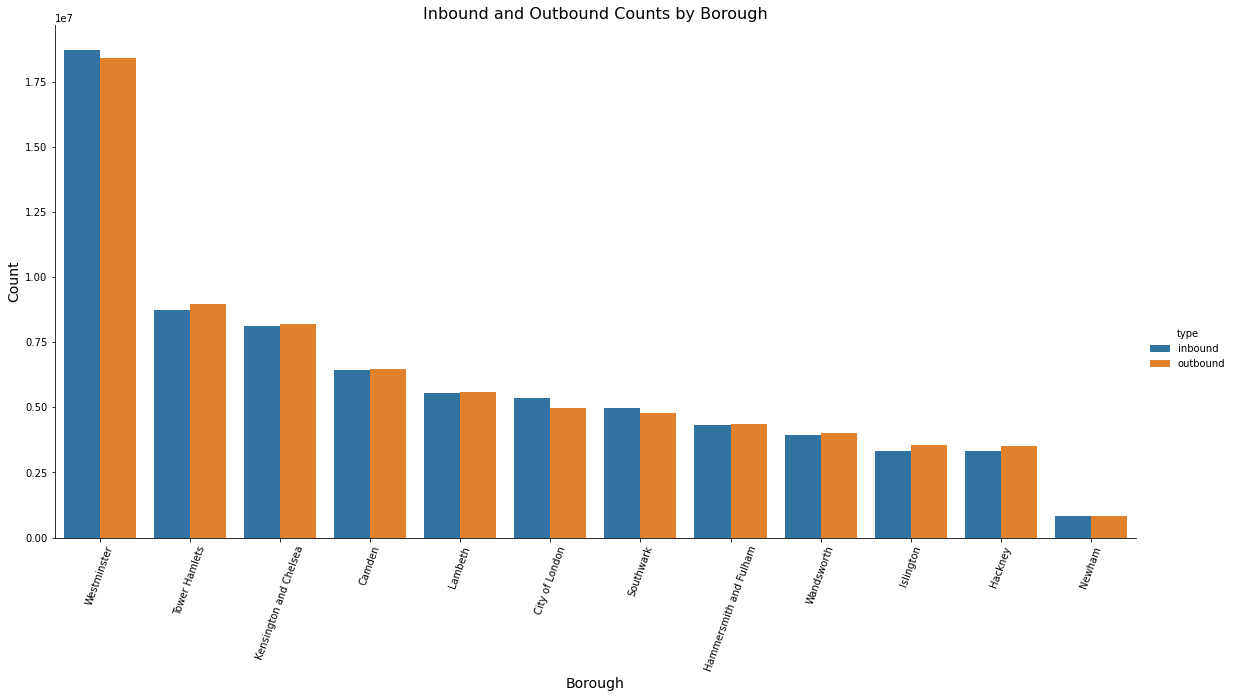

<Figure size 432x288 with 0 Axes>

In [7]:
# get count data
borough_counts = vis_flow.create_inbound_outbound_counts(journey_df)

# create plot
plot_inbound_outbound = vis_flow.create_inbound_outbound_plot(borough_counts)
plot_inbound_outbound.show()

### 4.2 Bike Journey Flow by Borough

In [69]:
journey_df_borough, boroughs_df = vis_flow.create_data_flowmap(journey_df)

In [8]:
# create and display Flowap.blue map

from IPython.display import IFrame
IFrame(src="https://flowmap.blue/1BEXz2CgyQ7USqEKgG9ZMThm6qIKdaTGCFW98VCgn4L4?v=51.505639%2C-0.097702%2C11.30%2C0%2C0&a=0&as=1&b=1&bo=75&c=0&ca=1&d=1&fe=1&lt=1&lfm=ALL&col=Default&f=50", width=1000, height=600)

# 5. DEMOGRAPHIC CHARACTERISTICS OF BOROUGHS ANALYSIS

In [48]:
# import borough data
borough_df = pd.read_csv('../data/interim/borough_data_featureeng.csv')


# import journey data, filter for 2019
journey_df = pd.read_csv('../data/interim/journey_data_cleaned_featureeng_1_2_3.csv', 
                         parse_dates=['start_date', 'end_date'])
journey_df = preprocess.filter_date(journey_df, datetime(2019, 1, 1), datetime(2019, 12, 31))

In [63]:
# aggregeate yearly demand 
borough_df = vis_boroughs.add_yearly_demands(borough_df, journey_df)
borough_df.head()


borough  bike_station_counts borough_code  \
0             Westminster                  171    E09000033   
1           Tower Hamlets                  116    E09000030   
2  Kensington and Chelsea                   94    E09000020   
3                  Camden                   64    E09000007   
4                 Lambeth                   59    E09000022   

   population_density   age_mean  age_25_percentile  age_75_percentile  \
0              9514.2  38.280112                 24                 53   
1             15702.9  31.984699                 21                 42   
2             11816.5  39.951470                 24                 56   
3              9640.9  37.006034                 22                 52   
4             11839.1  35.826829                 24                 49   

   female_ratio  householdsize_1_ratio  householdsize_2_ratio  ...  \
0      0.515712               0.426546               0.301693  ...   
1      0.497693               0.319656               0.310580  ...   
2      0.532255               0.437055               0.289127  ...   
3      0.526573               0.387345               0.309217  ...   
4      0.515382               0.320404               0.332989  ...   

   occupation_high_level_ratio_ratio  \
0                           0.443089   
1                           0.397595   
2                           0.460353   
3                           0.448063   
4                           0.452817   

   occupation_small_intermediate_ratio_ratio  \
0                                   0.161098   
1                                   0.149093   
2                                   0.177567   
3                                   0.157334   
4                                   0.171754   

   occupation_lower_level_ratio_ratio  occupation_unemployed_ratio_ratio  \
0                            0.148262                           0.118178   
1                            0.185841                           0.136711   
2                            0.144639                           0.104780   
3                            0.144260                           0.098225   
4                            0.203337                           0.084490   

   occupation_student_ratio_ratio  earnings_workplace  \
0                        0.129374               60046   
1                        0.130760               69264   
2                        0.112661               41723   
3                        0.152118               49239   
4                        0.087602               48333   

   demand_19_start_borough  demand_19_end_borough  \
0                  2507361                2568590   
1                  1218646                1182429   
2                  1111799                1093913   
3                   963135                 960684   
4                   811940                 798973   

   demand_stand_19_start_borough  demand_stand_19_end_borough  
0                   14662.929825                 15020.994152  
1                   10505.568966                 10193.353448  
2                   11827.648936                 11637.372340  
3                   15048.984375                 15010.687500  
4                   13761.694915                 13541.915254  

[5 rows x 78 columns]

### 5.1 Scatterplot of all Features and Yearly Demand 2019

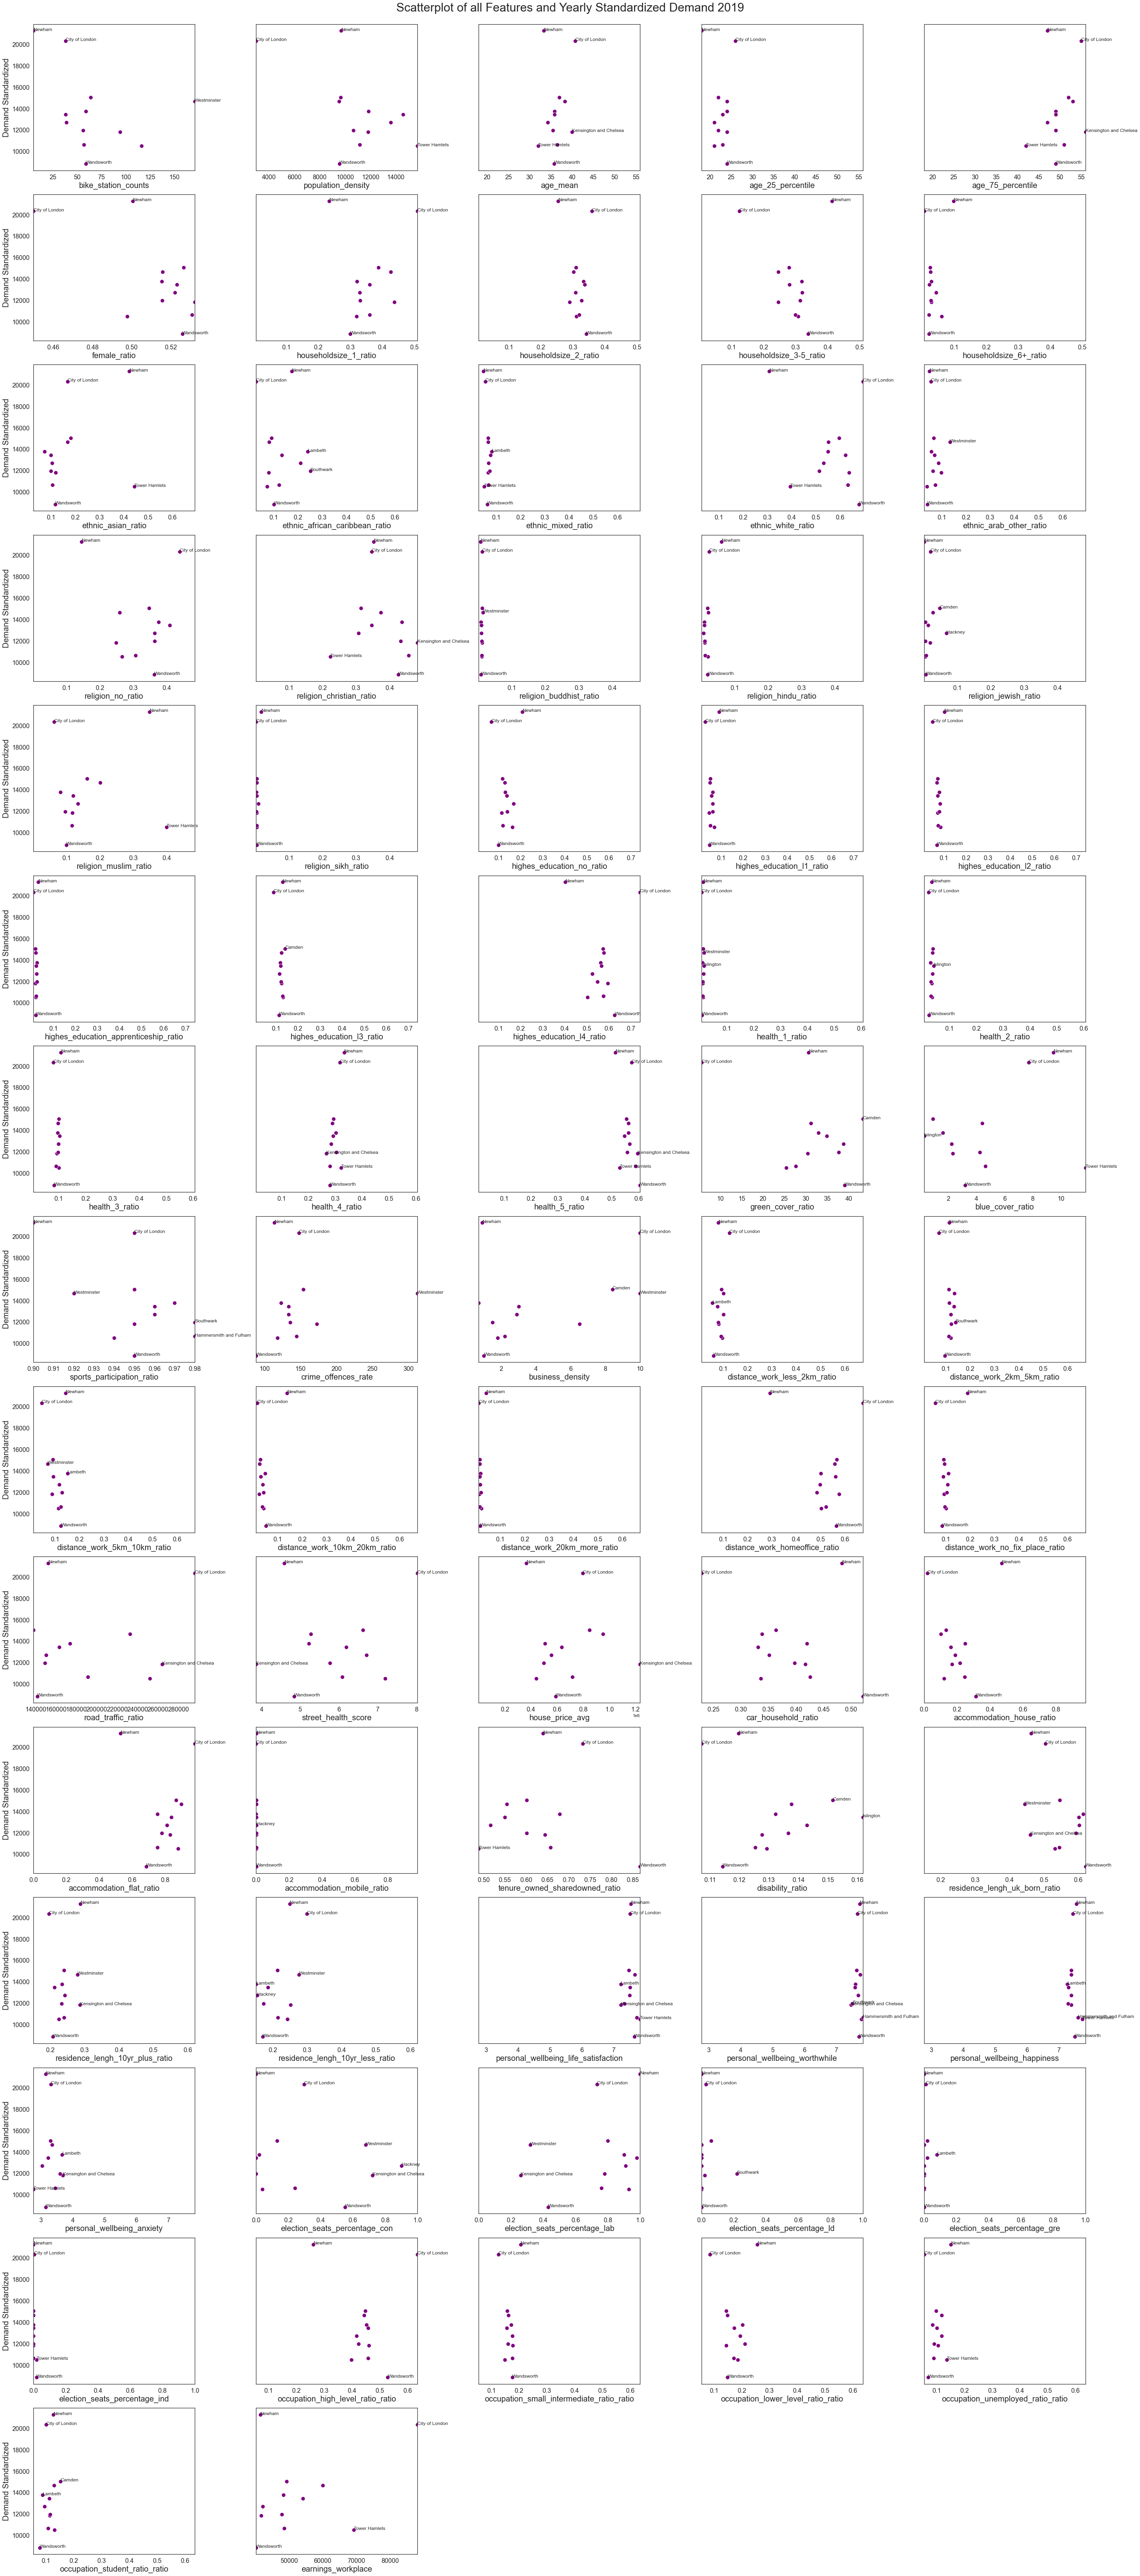

In [68]:
scatterplot_demand_stand = vis_boroughs.scatterplot_borough_charactersitics(borough_df, 'demand_stand_19_start_borough', 'Scatterplot of all Features and Yearly Standardized Demand 2019')
scatterplot_demand_stand.show()

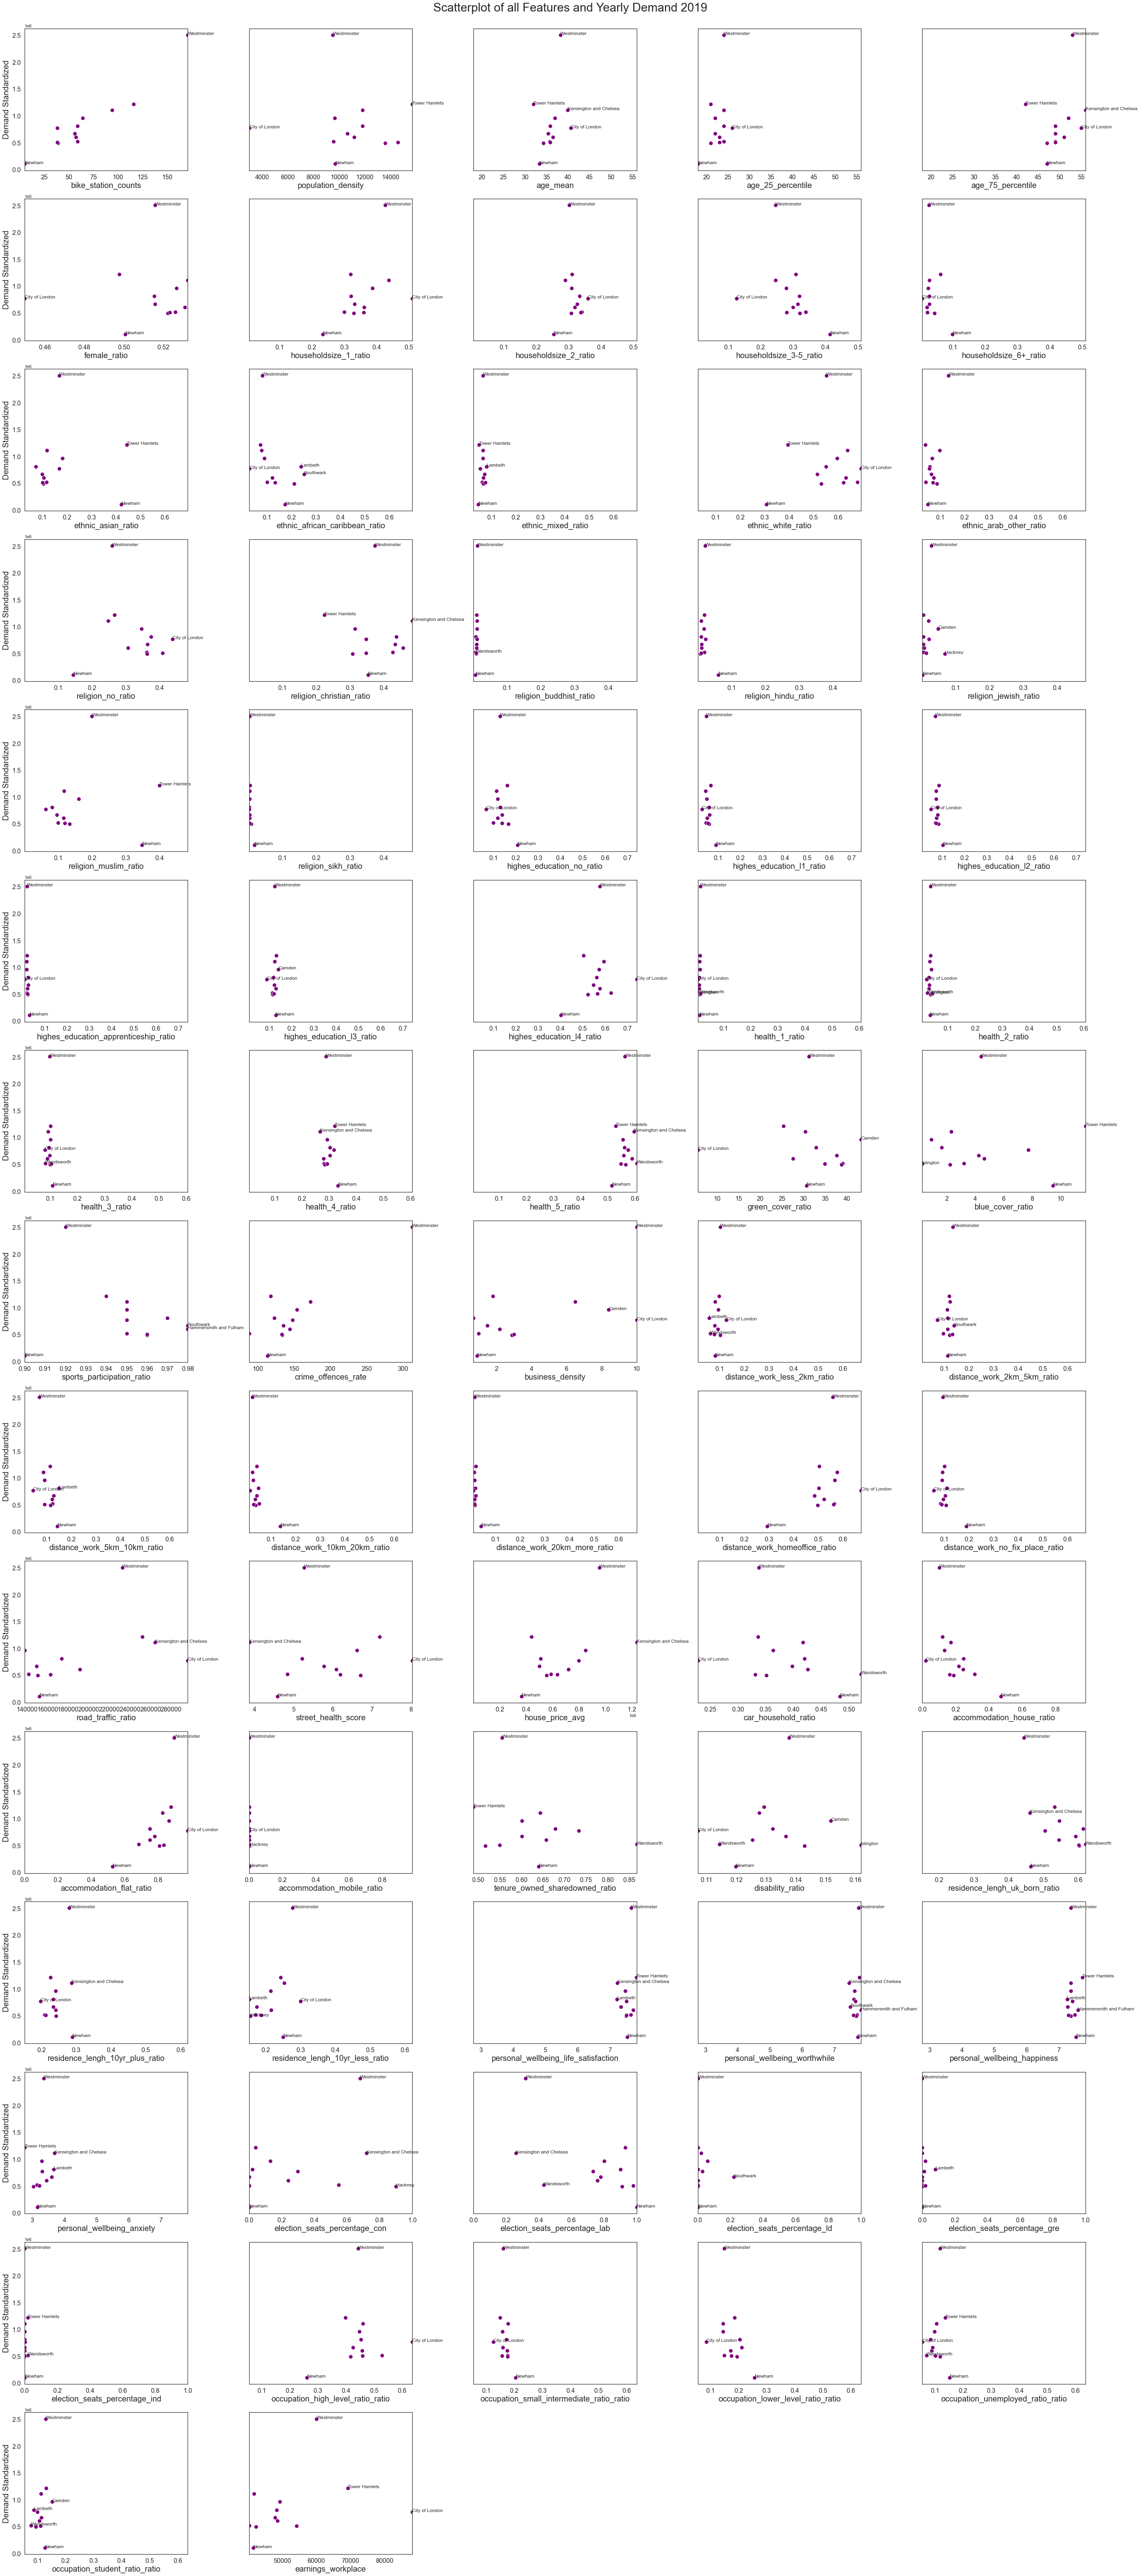

In [69]:
scatterplot_demand_stand = vis_boroughs.scatterplot_borough_charactersitics(borough_df, 'demand_19_start_borough', 'Scatterplot of all Features and Yearly Demand 2019')
scatterplot_demand_stand.show()

### 5.2 Correlation Matrix of Features against Demands 2019

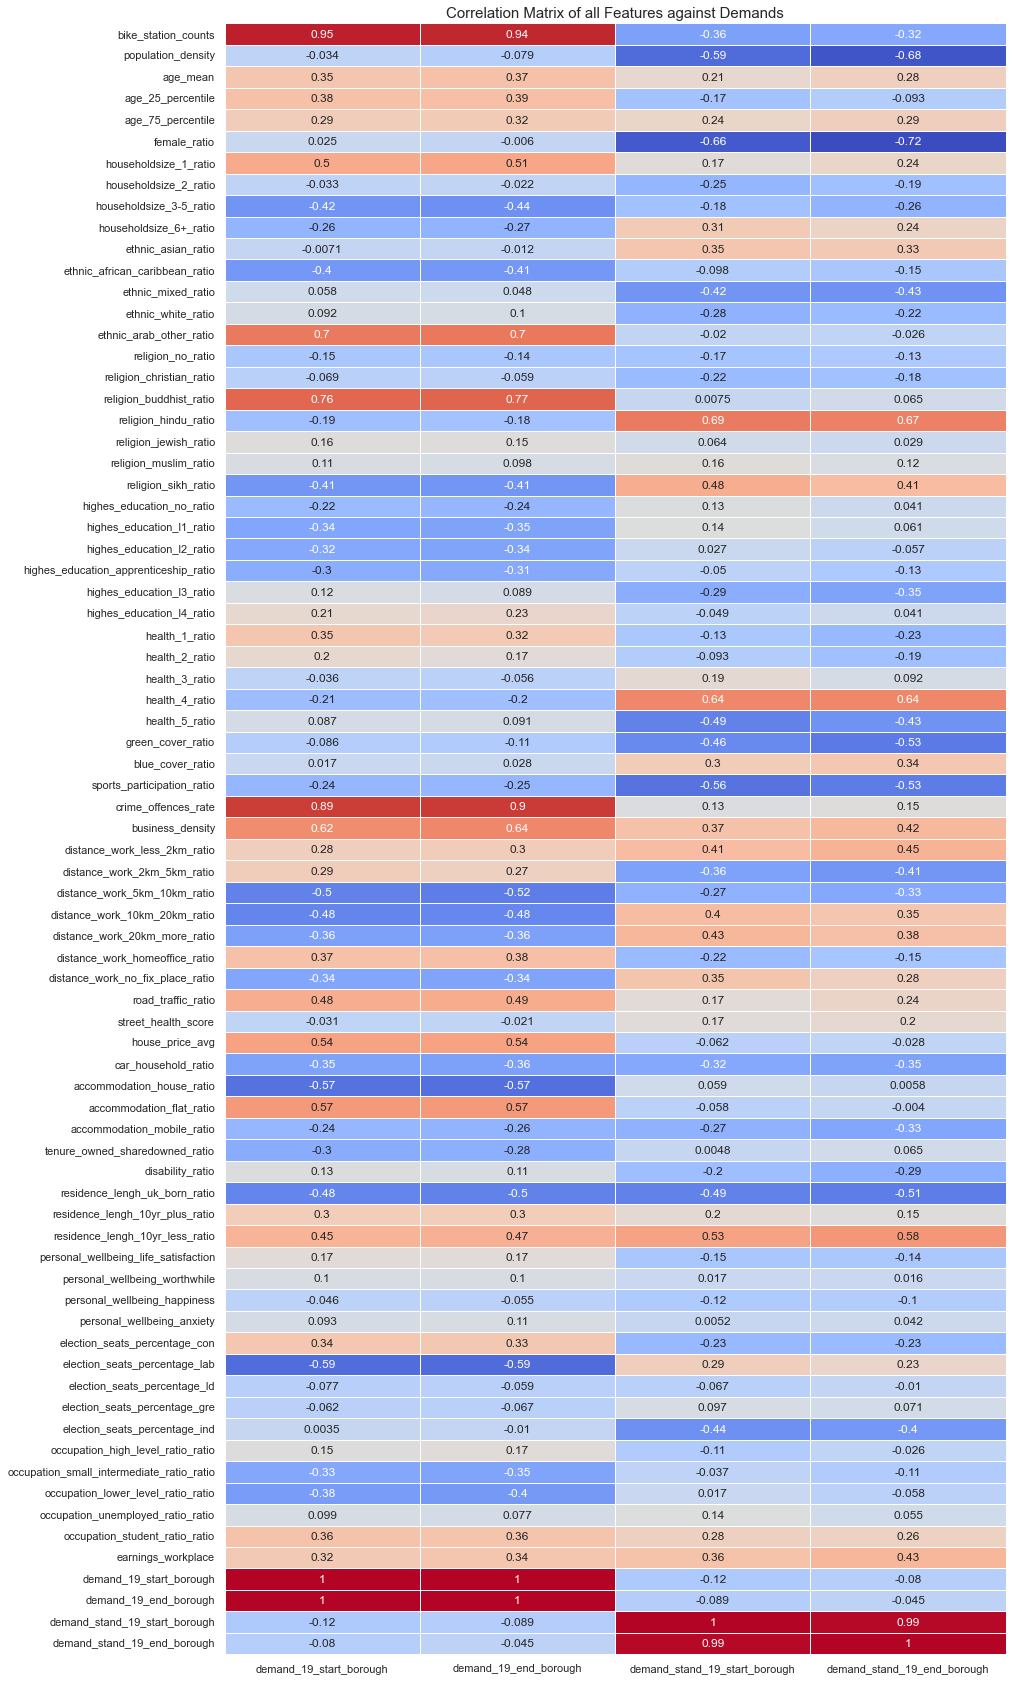

In [67]:
heatmap_demand_stand = vis_boroughs.heatmap_borough_charactersitics(borough_df)
heatmap_demand_stand.show()